In [1]:
__author__ = "Karolina Stosio"
__copyright__ = "Copyright 2017, AI Research, Data Technology Centre, Volkswagen Group"
__credits__ = ["Karolina Stosio"]
__license__ = "MIT"
__maintainer__ = "Karolina Stosio"

import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image,ImageFilter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [2]:
PATH = '/home/karolina/Documents/VW/unsupervised_data'

In [113]:
class Data:
    """Class for reading in, preprocessing and feature extraction for training data"""
    
    def __init__(self, path):
        self.features_files = glob.glob(path+'/*/output/My Snapshot*.jpg.features.npy')
        self.masks_files = glob.glob(path+'/*/output/My Snapshot*.jpg.mask.npy')
        self.original_images = glob.glob(path+'/*/My Snapshot*.jpg')
        self.masks_images = glob.glob(path+'/*/output/My Snapshot*.jpg.png')
        self.features_files.sort()
        self.masks_files.sort()
        self.original_images.sort()
        self.masks_images.sort()
        self.N_files = len(self.features_files)
        self._calculate_colours_vector()
        self._update_files_lists()
        self.features = self.get_features_all_files()
        
    def _check_mask(self,mask_file):
        mask = np.load(mask_file)
        if not ((np.max(mask) - np.min(mask)) == 0):
            return (True, mask_file.split('/')[6])
        else:
            return (False, None)
    
    def _filter_files(self):
        indices = [self._check_mask(m)[0] for m in self.masks_files]
        return indices
    
    def _update_files_lists(self):
        idx = self._filter_files()
        self.features_files = np.array(self.features_files,dtype=object)[idx]
        self.masks_files = np.array(self.masks_files,dtype=object)[idx]
        self.original_images = np.array(self.original_images,dtype=object)[idx]
        self.masks_images = np.array(self.masks_images,dtype=object)[idx]
    
    def _calculate_colours_vector(self):
        good_masks = [self._check_mask(m)[1] for m in self.masks_files]
        good_masks = list(filter(None, good_masks))
        self.N_good_files = len(good_masks)
        a = [[good_masks.count(x) for x in set(good_masks)][i]*[i] for i in range(len(set(good_masks)))]
        colours_vector = []
        for el in a:
            colours_vector += el
        self.colours_vector = np.array(colours_vector)
        
    def _get_features_one_image(self, features_file, mask_file):
        """
        Determines the normalized features averaged over the space of the brick based on feature file and masked file. 
        """
        features = np.load(features_file)
        mask = np.load(mask_file)
        #mask[mask!=0]=1

        feature_vec = np.empty((features.shape[2]),dtype=object)
        for i in range(features.shape[2]):
            feature_vec[i] = np.sum(mask*features[:,:,i])
            if np.isnan(feature_vec[i]):
                raise NameError('Empty feature vector')
        if (np.max(feature_vec)- np.min(feature_vec)) == 0: #should not happen -> use cleaned-up list
            return np.array([None]*512)
        colours = self._extract_img_features()
        feature_vec = np.concatenate((feature_vec,colours))
        return (feature_vec - np.min(feature_vec))/(np.max(feature_vec)- np.min(feature_vec))

    def get_features_all_files(self):
        X = np.zeros((self.N_good_files, 512+3))
        for i in range(self.N_good_files):
            self.current_file_index = i
            X[i] = self._get_features_one_image(self.features_files[i],self.masks_files[i])
        return X
    
    def _read_images(self,num=0):
        img = Image.open(self.original_images[num])
        mask = Image.open(self.masks_images[num])
        #imageBox = img.getbbox()
        #img = img.crop(imageBox)
        img = img.filter(ImageFilter.GaussianBlur(radius=3))
        img = img.convert('RGB')
        mask = mask.convert('RGB')
        img = img.resize(mask.size,Image.ANTIALIAS)
        return img,mask

    def _mask_images(self,num=0):
        img,mask = self._read_images(num=num)
        img = (np.array(img)).astype('uint8')
        mask = (np.array(mask).astype('uint8'))
        mask[mask!=0]=1
        masked = mask*img
        img = Image.fromarray(masked, 'RGB')
        return img
    
    def _extract_img_features(self):
        n = self.current_file_index
        img = self._mask_images(n)
        img = (np.array(img)).astype('uint8')
        return np.mean(img,axis=(0,1))

    def mask_images_2(dat=dat,num=0):
        _m = np.load(self.masks_files[num]).astype('uint8')
        img4 = Image.fromarray(_m)
        img4 = img4.resize((854, 480),Image.ANTIALIAS)
        img4 = img4.convert('RGB')
        img4 = (np.array(img4)).astype('uint8')
        img,_ = read_images(dat=dat,num=n)
        #img4[img4!=0]=1
        masked = img*img4
        masked = Image.fromarray(masked, 'RGB')
        return masked

In [114]:
dat = Data(PATH)

In [115]:
_X = dat.features
_xx = _X[:,-3:]

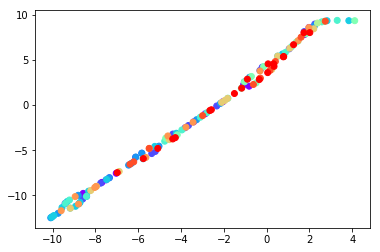

In [116]:
X_embedded = TSNE(n_components=2).fit_transform(_xx)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c = np.array(dat.colours_vector), cmap=plt.cm.rainbow)
plt.show()

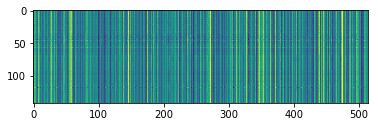

In [117]:
plt.imshow(_X)

In [118]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(_X)


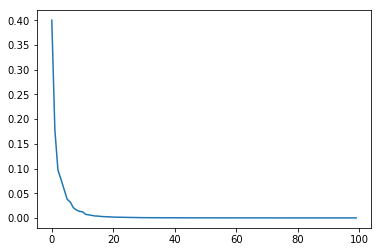

In [119]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

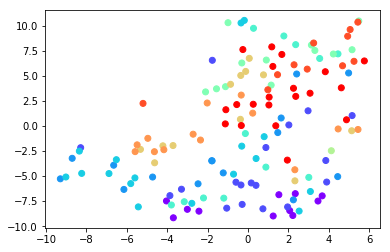

In [126]:
pca = KernelPCA(n_components=50)
X_pca = pca.fit_transform(_X)
X_embedded = TSNE(n_components=2).fit_transform(X_pca)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c = np.array(dat.colours_vector), cmap=plt.cm.rainbow)
plt.show()

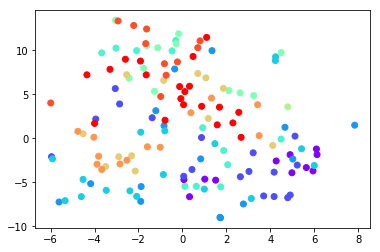

In [121]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(_X)
X_embedded = TSNE(n_components=2).fit_transform(X_pca)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = np.array(dat.colours_vector), cmap=plt.cm.rainbow)
plt.show()

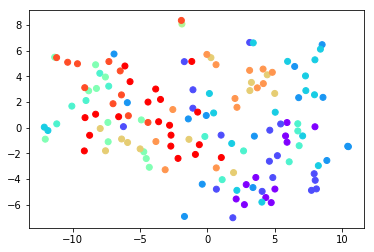

In [122]:
X_embedded = TSNE(n_components=2).fit_transform(_X)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = np.array(dat.colours_vector), cmap=plt.cm.rainbow)
plt.show()

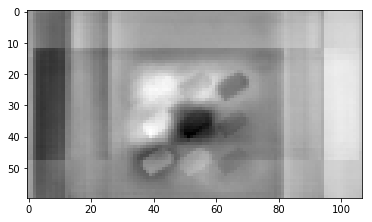

In [105]:
plt.imshow(np.load(dat.features_files[0])[:,:,1], cmap=plt.get_cmap('gray'))
plt.show()

In [25]:
def read_images(dat=dat,num=0):
    img = Image.open(dat.original_images[num])
    mask = Image.open(dat.masks_images[num])
    #imageBox = img.getbbox()
    #img = img.crop(imageBox)
    
    img = img.filter(ImageFilter.GaussianBlur(radius=3))
    img = img.convert('RGB')
    mask = mask.convert('RGB')
    img = img.resize(mask.size,Image.ANTIALIAS)
    return img,mask

def mask_images(dat=dat,num=0):
    img,mask = read_images(dat=dat,num=num)
    img2 = (np.array(img)).astype('uint8')
    mask2 = (np.array(mask).astype('uint8'))
    #mask2[mask2!=0]=1
    masked = mask2*img2
    img3 = Image.fromarray(masked, 'RGB')
    return img3

def mask_images_2(dat=dat,num=0):
    _m = np.load(dat.masks_files[num]).astype('uint8')
    img4 = Image.fromarray(_m)
    img4 = img4.resize((854, 480),Image.ANTIALIAS)
    img4 = img4.convert('RGB')
    img4 = (np.array(img4)).astype('uint8')
    img,_ = read_images(dat=dat,num=n)
    img2 = (np.array(img)).astype('uint8')
    #img4[img4!=0]=1
    masked = img*img4
    masked = Image.fromarray(masked, 'RGB')
    return masked

In [65]:
img,mask = read_images(dat=dat,num=12)

In [66]:
def mask_images(dat=dat,num=0):
    img,mask = read_images(dat=dat,num=num)
    img2 = (np.array(img)).astype('uint8')
    mask2 = (np.array(mask).astype('uint8'))
    #mask2[mask2!=0]=1
    masked = mask2*img2
    img3 = Image.fromarray(masked, 'RGB')
    return img3

def mask_images_2(dat=dat,num=0):
    _m = np.load(dat.masks_files[num]).astype('uint8')
    img4 = Image.fromarray(_m)
    img4 = img4.resize((854, 480),Image.ANTIALIAS)
    img4 = img4.convert('RGB')
    img4 = (np.array(img4)).astype('uint8')
    img,_ = read_images(dat=dat,num=n)
    img2 = (np.array(img)).astype('uint8')
    #img4[img4!=0]=1
    masked = img*img4
    masked = Image.fromarray(masked, 'RGB')
    return masked

In [71]:
n = 16

In [72]:
masked = mask_images(dat=dat,num=n)
masked2 = mask_images_2(dat=dat,num=n)

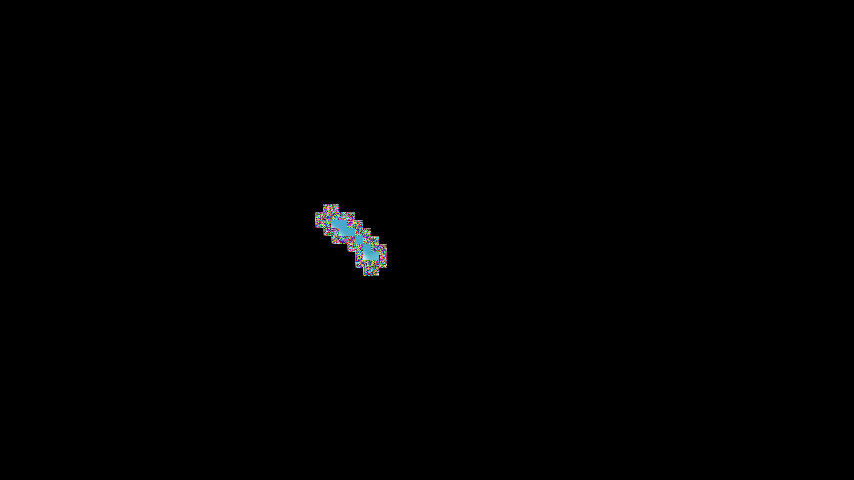

In [73]:
masked

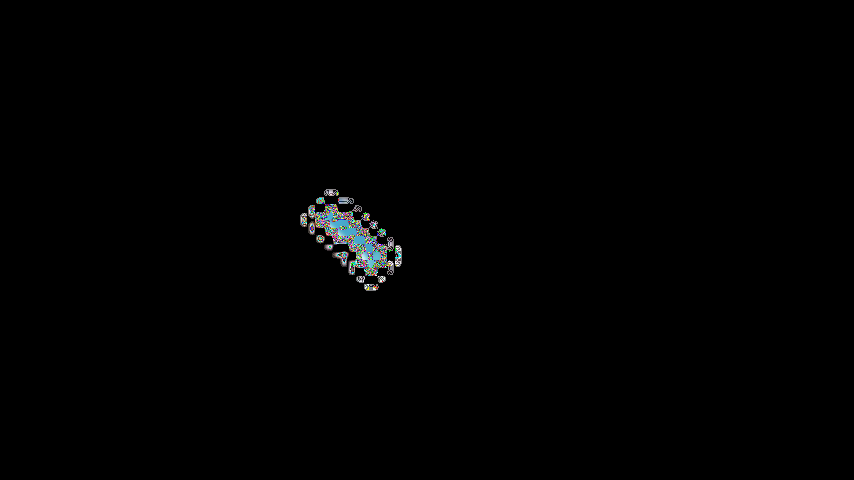

In [74]:
masked2

In [52]:
m=(np.array(masked2)).astype('uint8')